# Building a Conversational AI Assistant with LangGraph

This notebook demonstrates how to build a conversational AI assistant using LangGraph that can help businesses, marketers, analysts, and investors monitor and analyze competitor activity in retail, with a special focus on clothing stores in high-traffic urban locations.

## Key Features

- **Competitor Insights**: Provides real-time information on nearby clothing store competitors
- **Business Strategy Support**: Generates actionable insights for market positioning
- **Marketing Optimization**: Assists in identifying trends and optimizing campaigns
- **Location Analysis**: Provides data for real estate and location analysts
- **Investment Analysis**: Supports investors in assessing business potential and risks

## Architecture

The system uses LangGraph to create a conversational agent with tool integration, allowing it to search for real-time information and provide comprehensive business insights.


In [ ]:
# Install required dependencies
!pip install -q langgraph==0.2.59

## 1. Import Required Libraries

First, we import all the necessary libraries for building our conversational AI assistant:


In [ ]:
# Core LangGraph imports for building the conversational agent
from langgraph.graph import StateGraph, MessagesState, START, END
from typing import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import ToolNode
from IPython.display import Image
from dotenv import load_dotenv, find_dotenv
from typing import Annotated
from langgraph.graph.message import add_messages
import os
from langchain_core.prompts import ChatPromptTemplate

In [ ]:
# Import search tool for real-time information gathering
from langchain_community.tools.tavily_search import TavilySearchResults

## 2. Environment Setup

Load environment variables and configure API keys:


In [ ]:
# Load environment variables from .env file
_ = load_dotenv(find_dotenv())
OPENAI_KEY = os.environ['OPENAI_API_KEY']

## 3. Define State Schema

The `MessagesState` defines the structure of our conversation state, which maintains a list of messages throughout the conversation:


In [ ]:
# Define the state schema for our conversational agent
class MessagesState(TypedDict):
    messages: Annotated[list, add_messages]  # List of conversation messages

## 4. Initialize Language Model

Configure the OpenAI language model for our conversational agent:


In [ ]:
# Initialize the language model with GPT-4o-mini for cost efficiency
llm = ChatOpenAI(model='gpt-4o-mini', temperature=0)

## 5. Create System Prompt

Define the system prompt that establishes the AI assistant's role and capabilities for business intelligence and competitor analysis:


In [ ]:
# Create a comprehensive system prompt for the business intelligence assistant
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a Conversational AI Assistant designed to help businesses, marketers, analysts, and investors monitor and analyze competitor activity in retail, with a special focus on clothing stores in high-traffic urban locations.

Your core objectives are:

Competitor Insights – Provide real-time information on nearby clothing store competitors, including store footfall, busiest times, and peak customer hours.

Business Strategy Support – Generate actionable insights that help business owners and managers adjust strategies to improve market positioning.

Marketing Optimization – Assist marketing teams in identifying trends, optimizing promotions, and aligning campaigns with or against competitor activities.

Location Analysis – Provide data to real estate and location analysts on high-footfall times and ideal store placement for new launches.

Investment Analysis – Support investors and market analysts in assessing business potential, risks, and opportunities in competitive retail areas.

Guidelines for Response:

Always provide insights in a clear, structured, and business-oriented format.

Where possible, highlight trends, risks, and opportunities.

Adapt explanations for the intended beneficiary (business owner, marketer, analyst, or investor).

Use a professional, analytical, and action-driven tone.

If real-time or location-specific data is requested, explain how it would be obtained (e.g., search, analytics, external APIs) and provide example insights."""),
    ("human", "{message}")
])

## 6. Define Agent Functions

Create the core functions that will power our conversational agent:


In [ ]:
# Function to call the language model with the current conversation state
def call_model(state: MessagesState):
    messages  = state['messages']
    llm_chain = prompt | llm
    response = llm_chain.invoke({"messages": messages})
    
    return {'messages':  response}

In [ ]:
# Function to determine whether to continue with tool calls or end the conversation
def should_continue(state: MessagesState) -> bool:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:  # If the LLM wants to use tools
        return 'tools'
    else:  # If no tools needed, end the conversation
        return END

## 7. Initialize the Graph

Create the StateGraph that will orchestrate our conversational agent:


In [ ]:
# Initialize the StateGraph with our MessagesState schema
graph = StateGraph(MessagesState)

## 8. Configure Tools

Set up the search tool that will allow our agent to gather real-time information:


In [ ]:
# Configure Tavily search tool for real-time information gathering
search_tool = TavilySearchResults(max_results=5)
tools = [search_tool]

# Create a tool node to execute the tools
tool_node = ToolNode(tools)

## 9. Build the Graph Structure

Add nodes and edges to create the conversational agent workflow:


In [ ]:
# Add nodes to the graph: agent node and tools node
graph.add_node('agent', call_model)  # Main agent that processes messages
graph.add_node('tools', tool_node)   # Tool execution node

In [ ]:
# Set the starting point of the graph to the agent node
graph.add_edge(START, "agent")

In [ ]:
# Add conditional edges from agent to either tools or END based on should_continue function
graph.add_conditional_edges('agent', 
                            should_continue,
                            ["tools",END])

In [ ]:
# After tool execution, return control to the agent for processing results
graph.add_edge('tools', 'agent')

In [ ]:
# Set the entry point of the graph (alternative to add_edge(START, "agent"))
graph.set_entry_point('agent')

## 10. Compile and Visualize the Graph

Compile the graph into an executable format and visualize its structure:


In [ ]:
# Compile the graph into an executable format
graph_compiled = graph.compile()

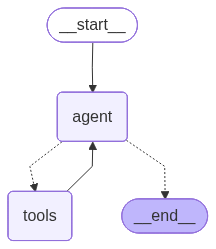

In [ ]:
# Visualize the graph structure to understand the workflow
Image(graph_compiled.get_graph().draw_mermaid_png())

## 11. Test the Conversational Agent

Now let's test our conversational AI assistant with various business intelligence queries:


In [ ]:
# Test 1: Competitor analysis query
output = graph_compiled.invoke({'messages': [
    ('user', 'Who are the top 5 clothing store competitors near Koramangala, Bangalore, and when are their busiest hours?')
]})
print(output["messages"][-1].content)

While I can't provide real-time data or specific current details, I can suggest some popular clothing stores in and around Koramangala, Bangalore, that are known to be competitive in the retail market. Here are five notable clothing stores:

1. **H&M** - A global fashion retailer known for trendy clothing at affordable prices.
2. **Zara** - Offers a wide range of stylish clothing and is popular for its fast-fashion approach.
3. **FabIndia** - Specializes in traditional Indian clothing and handloom products, appealing to both locals and tourists.
4. **Levi's** - Known for denim and casual wear, Levi's has a strong presence in the market.
5. **Lifestyle** - A department store that offers a variety of clothing brands under one roof, catering to different styles and budgets.

### Busiest Hours
Typically, the busiest hours for clothing stores are:

- **Weekdays (Monday to Friday)**: 5 PM to 8 PM, as people tend to shop after work.
- **Weekends (Saturday and Sunday)**: 11 AM to 3 PM and 5 PM

In [ ]:
# Test 2: Marketing optimization query
output = graph_compiled.invoke({'messages': [
    ('user', 'How can we optimize promotions for the upcoming festive season based on footfall trends in Indiranagar?')
]})
print(output["messages"][-1].content)

Optimizing promotions for the upcoming festive season in Indiranagar, or any specific area, requires a data-driven approach that takes into account footfall trends, customer behavior, and local preferences. Here are several strategies to consider:

### 1. **Analyze Footfall Data**
   - **Historical Data Review**: Look at footfall data from previous festive seasons to identify peak times and trends. Analyze which days had the highest foot traffic and what types of promotions were most effective.
   - **Real-Time Analytics**: Use footfall tracking technology (like sensors or mobile data) to monitor current trends. This can help you adjust promotions dynamically.

### 2. **Targeted Promotions**
   - **Segmented Offers**: Create promotions tailored to different customer segments based on their shopping habits. For example, offer discounts on popular items during peak hours or special deals for families.
   - **Time-Limited Offers**: Implement flash sales or limited-time offers during high 

In [ ]:
# Test 3: Location analysis query
output = graph_compiled.invoke({'messages': [
    ('user', 'Identify the best locations in Whitefield for launching a new mid-range clothing store, based on competitor activity.')
]})
print(output["messages"][-1].content)

To identify the best locations in Whitefield for launching a new mid-range clothing store, it's essential to consider several factors, including competitor activity, foot traffic, demographics, and accessibility. Here are some key areas and considerations:

1. **Forum Neighbourhood Mall**: This is one of the most popular shopping destinations in Whitefield. The presence of various retail brands can attract a significant number of shoppers. An analysis of competitors in the mall can help identify gaps in the market.

2. **Phoenix Marketcity**: Another major shopping hub, Phoenix Marketcity, has a diverse range of retail options. Observing the types of clothing stores present and their price points can help position your store effectively.

3. **ITPL Main Road**: This area is bustling with IT professionals and has a high footfall due to nearby tech parks. A mid-range clothing store here could cater to the working population looking for convenient shopping options.

4. **Whitefield Main R

## Summary

This notebook demonstrates how to build a sophisticated conversational AI assistant using LangGraph that can:

1. **Process Natural Language Queries**: Accept business intelligence questions in natural language
2. **Integrate with External Tools**: Use Tavily search to gather real-time information
3. **Maintain Conversation Context**: Track the conversation state throughout the interaction
4. **Provide Business Insights**: Generate structured, actionable recommendations for various stakeholders

### Key Components:

- **State Management**: Uses `MessagesState` to maintain conversation history
- **Tool Integration**: Leverages Tavily search for real-time data gathering
- **Conditional Routing**: Intelligently decides when to use tools vs. providing direct responses
- **Business Focus**: Specialized for retail and clothing store competitive analysis

### Use Cases:

- **Competitor Analysis**: Identify and analyze competing businesses
- **Marketing Optimization**: Develop data-driven promotional strategies
- **Location Intelligence**: Assess optimal locations for new store launches
- **Investment Research**: Support investment decisions with market insights

The system is designed to be modular and extensible, allowing for easy addition of new tools and capabilities as business needs evolve.
